In [1]:
# matplotlib inline
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D
from keras import optimizers, regularizers, initializers
from datetime import datetime
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import csv
random_state = 100
np.random.seed(random_state)

Using TensorFlow backend.


In [2]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)

color_map = 'viridis'

### Import Data

In [3]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

coloumns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'value']
df_train.columns = coloumns
df_val.columns = coloumns
df_test.columns = coloumns

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [4]:
from keras.utils import to_categorical

mms = StandardScaler()
X_train = mms.fit_transform(df_train.drop('value', axis=1))
Y_train = to_categorical(df_train['value'].values)

X_val = mms.fit_transform(df_val.drop('value', axis=1))
Y_val = to_categorical(df_val['value'].values)

X_test = mms.fit_transform(df_test.drop('value', axis=1))
Y_test = to_categorical(df_test['value'].values)

### Model setup

In [5]:
def get_saved_model():
    loaded_model = load_model('./logs/')
    loaded_model.load_weights('./logs/random_seed_1_999.hdf5')
    return loaded_model

def get_model(train_status, shape, random_seed):
    if train_status == 'new':   
        model = Sequential()
        model.add(Dense(12, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=random_seed), activation = 'relu', input_shape = (shape[0],), name='layer_1'))
        model.add(Dense(shape[1], activation="softmax", name='Output_layer'))
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        return model
    elif train_status == 'retrain':
        model = get_saved_model()
        model.compile('adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        return model

### build model

In [6]:
# Training
# random_seed=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60, 80, 100]
random_seed=[100]

In [10]:

training_epochs = 150
train_status = 'new' # retrain or new
filepath = './logs/random_seed_'+ str(random_seed[0]) +'_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=0, period=training_epochs)
callbacks_list = [checkpoint]

shape = [int(X_train.shape[1]), int(Y_train.shape[1])]
model = get_model(train_status, shape, random_seed[0])
class_weight = class_weight = {0 : 1, 1: 2.}

model.fit(X_train, Y_train, batch_size = 10, epochs = training_epochs, callbacks=callbacks_list,
          validation_data=(X_val, Y_val), class_weight = class_weight, verbose=0)

scores = model.evaluate(X_test, Y_test, batch_size=10)

 10/400 [..............................] - ETA: 0s

In [11]:
Y_pred = model.predict(X_test)
Y_test_class = np.argmax(Y_test, axis = 1)
Y_pred_class = np.argmax(Y_pred, axis = 1)

print(accuracy_score(Y_test_class, Y_pred_class))
print(classification_report(Y_test_class, Y_pred_class))

display(confusion_matrix(Y_test_class, Y_pred_class))

0.8125
             precision    recall  f1-score   support

          0       0.92      0.79      0.85       272
          1       0.66      0.85      0.74       128

avg / total       0.84      0.81      0.82       400



array([[216,  56],
       [ 19, 109]])

In [12]:
# arr = np.array([0.088, 1.304, -136.062, 51.391, -126.715, 0.346, 0.448, 0.406]) # 1
arr = np.array([0.104, 1.146, -102.509, 58.619, -117.766, 0.484, 0.217, 0.296]) # 0
test_data = arr.reshape(1,8)
test_data = mms.fit_transform(test_data)
Y_pred = model.predict(test_data)
print(Y_pred)

[[ 0.43078712  0.56921285]]


In [13]:
weight = weights = model.get_weights()
layer_1_weights = weights[0]
layer_2_weights = weights[1]

act = test_data.dot(layer_1_weights) 

<IPython.core.display.Javascript object>


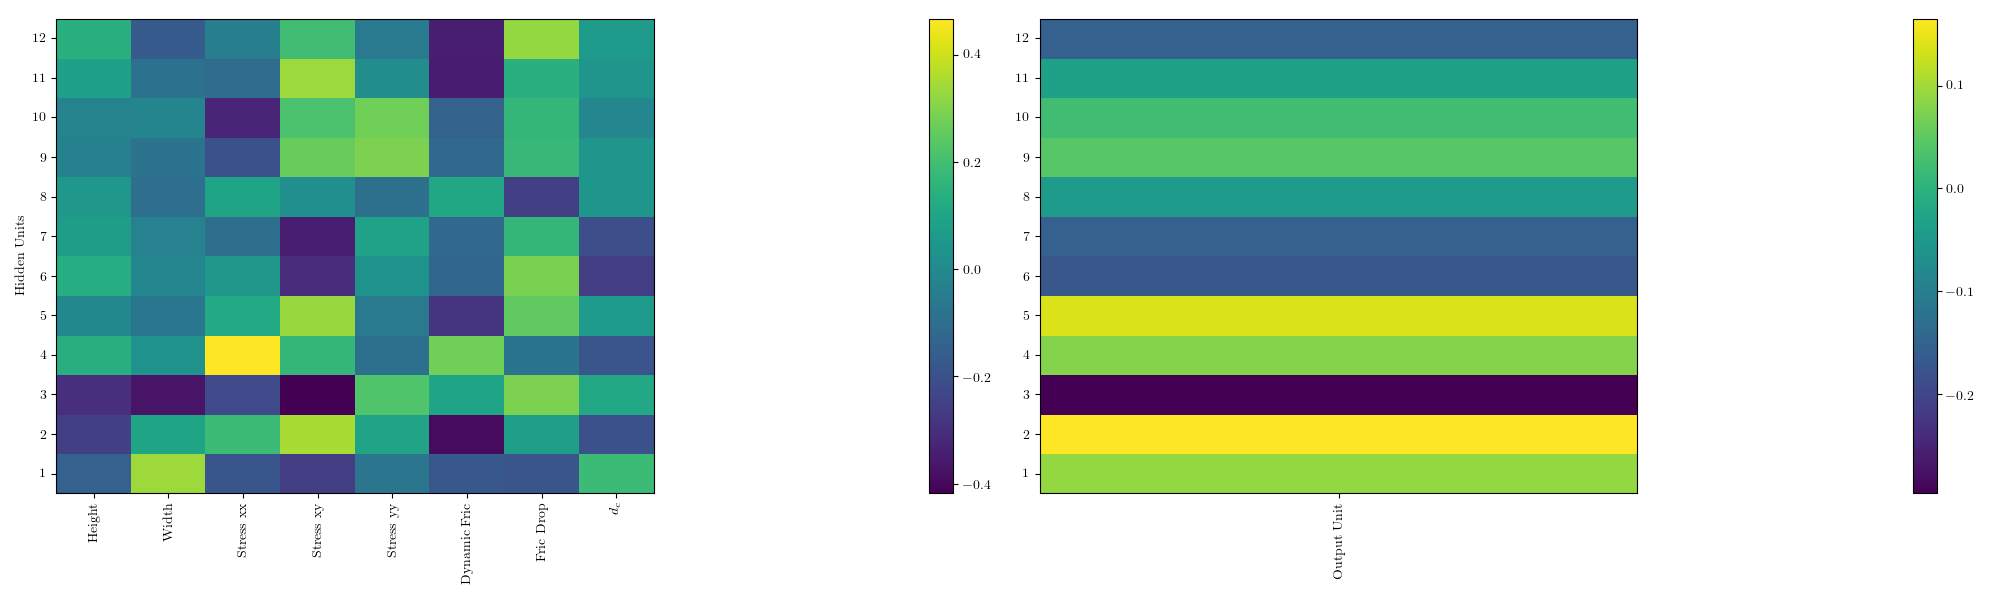

In [14]:
%matplotlib notebook

from matplotlib import ticker

plt.figure(figsize=(20, 6))
# plt.rcParams.update({'font.size': 18})
model_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_149.hdf5'
#     model.load_weights(filename)
    weights = model.get_weights()

    layer_1_weights = weights[0]    
    model_weights.append(layer_1_weights)
    plt.subplot(1,2, 1)
    plt.pcolormesh(np.transpose(layer_1_weights))
    labels = ['Height', 'Width', 'Stress xx', 'Stress xy', 'Stress yy', 'Dynamic Fric', 'Fric Drop', '$d_c$']
    plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    plt.ylabel('Hidden Units')
#     plt.title('Acc=%s\n seed=%s'%(round(new_scores[i], 2), random_seed[i]))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

    cb = plt.colorbar(orientation="vertical",fraction=0.05, pad=0.3)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    
    # Layer two plot
    plt.subplot(1, 2, 2)
    layer_2_weights = weights[1]
    bb = np.reshape(layer_2_weights, (12, 1))
    plt.pcolormesh(bb)
    plt.xticks([0.5],['Output Unit'],rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
    cb = plt.colorbar(orientation="vertical",fraction=0.05, pad=0.3)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

plt.tight_layout()
# plt.savefig('weight_vs_features.eps')
plt.show()


### Training Size testing

In [143]:
def build_model(Xtrain, Ytrain):
    for i in range(len(train_size)):
        training_epochs = 150
        train_status = 'new' # retrain or new
        shape = [int(Xtrain.shape[1]), int(Ytrain.shape[1])]
        model = get_model(train_status, shape, random_seed[0])

#         filepath = './logs/random_seed_'+ str(random_seed[i]) +'_{epoch:02d}.hdf5'
#         checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True, period=training_epochs)
    #   tbCallBack = TensorBoard(log_dir=path, histogram_freq=1, write_graph=True)

        model.fit(Xtrain, Ytrain, batch_size = 10, epochs = training_epochs, validation_data=(X_val, Y_val), verbose=0)
        scores = model.evaluate(X_test, Y_test, batch_size=10)
    return scores[1]

In [144]:
train_size = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
no_data = np.shape(X_train)[0]
scores = []
for i, value in enumerate(train_size):
    size = int((no_data*value)/100)
    acc = build_model(X_train[:size, :], Y_train[:size, :])
    scores.append(acc)
    print('finished iteration : {} of {}, acc : {}'.format(i, len(train_size), acc))

 10/400 [..............................] - ETA: 0sfinished iteration : 1 of 2, acc : 0.8224999994039536


In [145]:
print('Test score : {}'.format(scores))

Test score : [0.82249999940395357, 0.82249999940395357]


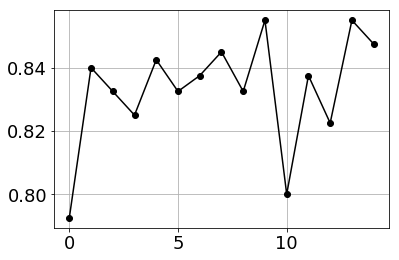

In [57]:
import pickle, os
# plt.style.use('classic')
file_name="rupture_scores.pkl"

if os.path.isfile(file_name):
    file = open(file_name, 'rb')
    data = pickle.load(file)
else:
    data ={'scores':scores}
    file = open(file_name, 'wb')
    pickle.dump(data, file)
    file.close()

new_scores= []
indexs = []
for i in range(len(data['scores'])):
    new_scores.append(data['scores'][i][1])
    indexs.append(i)
    
plt.plot(indexs, new_scores, '-ok')
plt.grid()
plt.savefig('accuracy.eps')
plt.show()

In [59]:
shape = [int(X_train.shape[1]), int(Y_train.shape[1])]
loaded_model = get_model(train_status, shape, random_state)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 12)                108       
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


## Plot flatten weights heatmap

In [8]:
flatten_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    weights = loaded_model.get_weights()
    layer_1_weights = weights[0]
    layer_1_weights = layer_1_weights.flatten()
    flatten_weights.append(layer_1_weights)

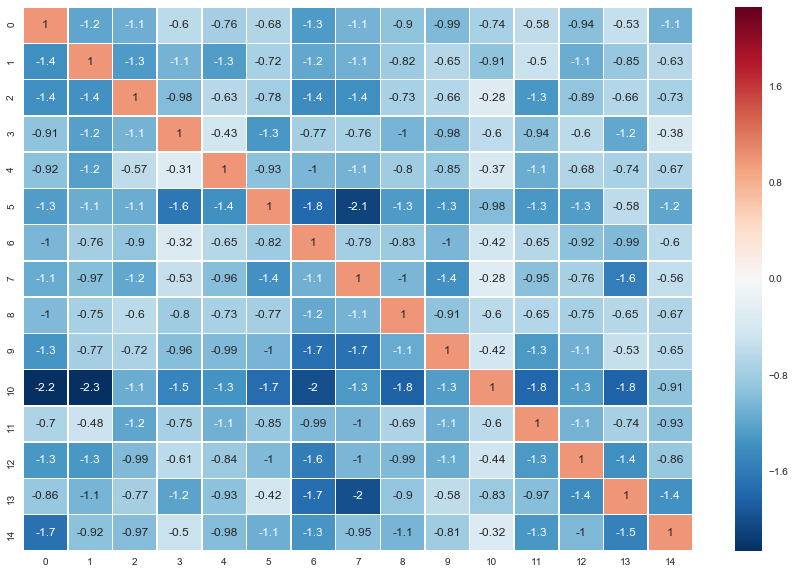

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
sns.set()

# Calculate r2_matrix
length = len(random_seed)
r2_matrix = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        r2_matrix[i][j] = r2_score(flatten_weights[i], flatten_weights[j])

# Plot
# mask = np.ones_like(corr)
# mask[np.triu_indices_from(mask, 1)] = False
# mask=mask
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(r2_matrix, annot=True, linewidths=.5)
plt.savefig('unsorted_corr.eps')

## plot sorted weight heatmap

In [60]:
flatten_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    weights = loaded_model.get_weights()
    layer_1_weights = weights[0]
    layer_1_weights = np.sort(layer_1_weights.flatten())
    flatten_weights.append(layer_1_weights)

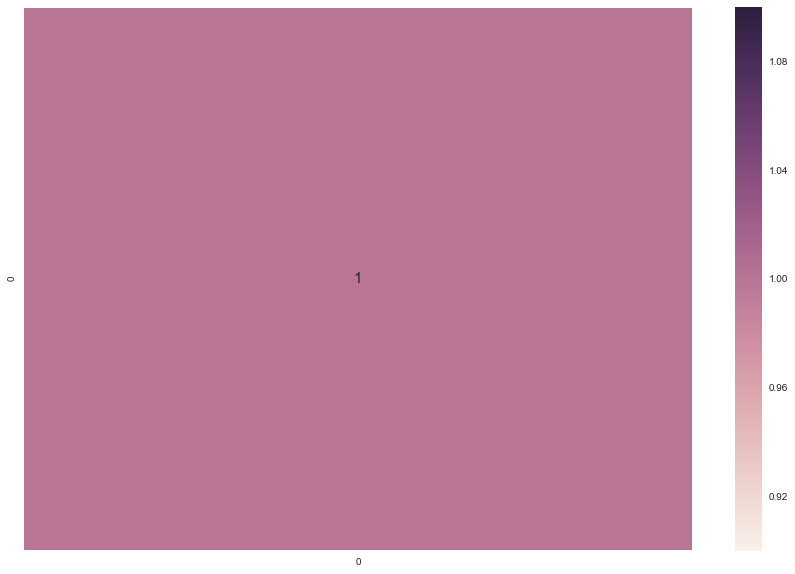

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
sns.set()

# Calculate r2_matrix
length = len(random_seed)
r2_matrix = np.zeros((length, length))
for i in range(length):
    for j in range(length):
        r2_matrix[i][j] = r2_score(flatten_weights[i], flatten_weights[j])

# Plot
plt.rcParams.update({'font.size': 15})
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(r2_matrix, annot=True, linewidths=.5)
plt.savefig('sorted_corr.eps')

## Prediction for different seed based models

In [15]:
from sklearn.metrics import precision_score, f1_score, fbeta_score, recall_score

score_f1 = []
score_precision = []
score_fbeta = []
score_recall = []

for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    Y_pred = loaded_model.predict(X_test)
    Y_test_class = np.argmax(Y_test, axis = 1)
    Y_pred_class = np.argmax(Y_pred, axis = 1)
    score_precision.append(precision_score(Y_test_class, Y_pred_class))
    score_f1.append(f1_score(Y_test_class, Y_pred_class))
    score_fbeta.append(fbeta_score(Y_test_class, Y_pred_class, 0.5))
    score_recall.append(recall_score(Y_test_class, Y_pred_class))

## Plot different evaluation metric

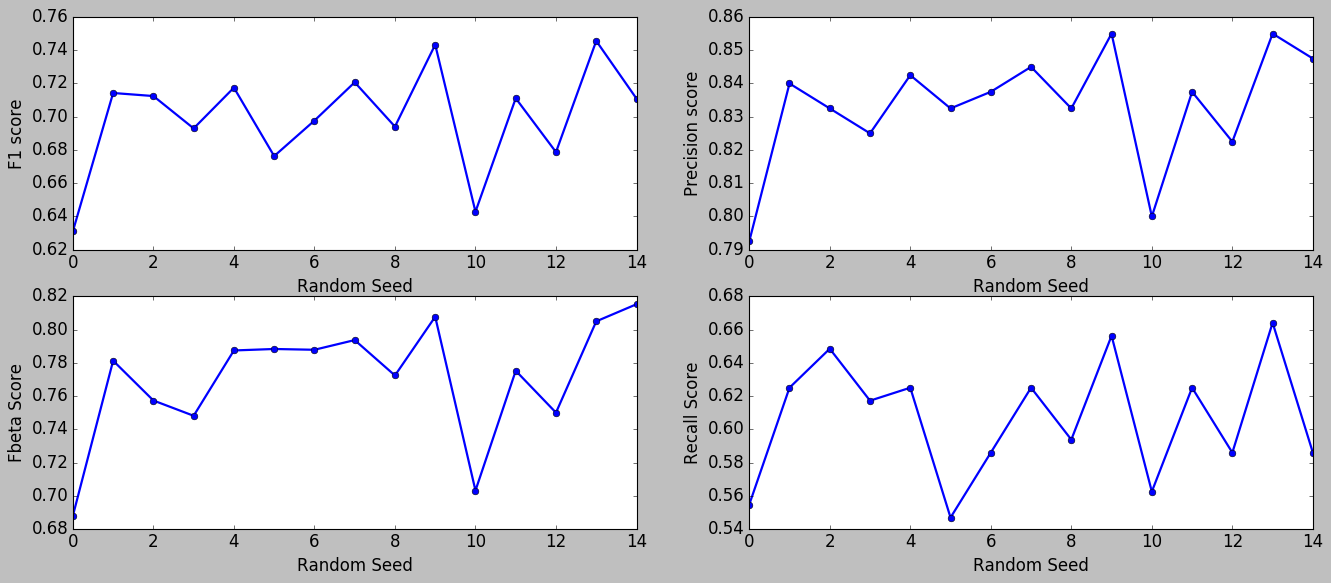

In [18]:
# plt.style.use('classic')
plt.rcParams.update({'font.size': 15})
plt.rc('lines', linewidth=2, color='k')
plt.figure(figsize=(20,8))

metric = [score_f1, score_acc, score_fbeta, score_recall]
ylabel = ['F1 score', 'Precision score', 'Fbeta Score', 'Recall Score']

for i in range(4):
    plt.subplot(2,2, i+1)
    plt.plot(metric[i], '-o')
    plt.xlabel('Random Seed')
    plt.ylabel(ylabel[i])
plt.savefig('scores.eps')
plt.show()

In [15]:
weight_mean =[]
weight_max =[]
weight_min =[]
for i in range(len(model_weights)):
    x = np.matrix(model_weights[i])
    weight_mean.append(x.mean())
    weight_max.append(x.max())
    weight_min.append(x.min())

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(weight_mean, '-r')

plt.subplot(1,3,2)
plt.plot(weight_max, '-k')

plt.subplot(1,3,3)
plt.plot(weight_min, '-b')
plt.show()
    

NameError: name 'model_weights' is not defined

In [71]:
Y_pred = loaded_model.predict(X_test)
Y_test_class = np.argmax(Y_test, axis = 1)
Y_pred_class = np.argmax(Y_pred, axis = 1)

In [72]:
print(accuracy_score(Y_test_class, Y_pred_class))
print(classification_report(Y_test_class, Y_pred_class))
print('---------- Confusion matrix ----------')
confusion_matrix(Y_test_class, Y_pred_class)

0.8475
             precision    recall  f1-score   support

          0       0.83      0.97      0.90       272
          1       0.90      0.59      0.71       128

avg / total       0.86      0.85      0.84       400

---------- Confusion matrix ----------


array([[264,   8],
       [ 53,  75]])

## Plot accuracy 

In [44]:
#print(history.history.keys())

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Training', 'Validation'], loc='lower right')


NameError: name 'history' is not defined

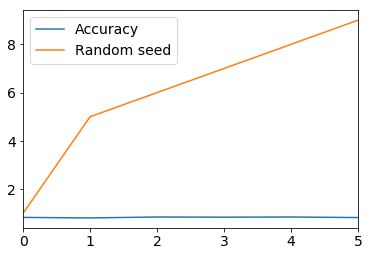

In [45]:
# model accuracy at different random seed
data = pd.DataFrame({'Random seed':[1, 5, 6, 7, 8, 9],
                     'Accuracy' : [0.8275, 0.8075, 0.845, 0.8375, 0.845, 0.8225]})
data.plot()

### best seed model

In [ ]:
random_seed = 100